# An example SPEX session in Jupyter Notebook


In this example, we show how to do a spectral fit with the Python interface to SPEX (pyspex). The first thing we need to do is to start a SPEX session in Python. We do that by importing the Session class from pyspex.spex and then we create a Session instance ```s``` which will be the pointer to our SPEX session:

In [1]:
from pyspex.spex import Session
s = Session()
%matplotlib inline

## Reading a dataset

Let's first read in the example dataset, which is a spectrum and response for the future XIFU instrument aboard Athena. This is done by calling the session method ```data``` and provide the filename for the res and spo file:

In [2]:
s.data('xifu.res','xifu.spo')

Using a plot, we can see what the data look like. So let's make a log-log plot to look at the spectrum:

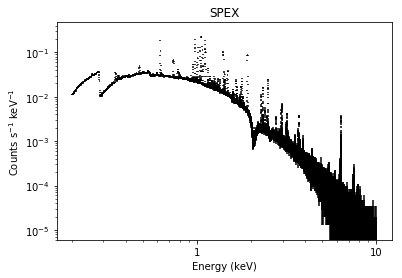

In [3]:
plt = s.plot_data(xlog=True, ylog=True, show=True)

## Ignoring spectral energy ranges

The energy intervals below 0.2 keV and above 10 keV do not contain useful data, so let's ignore them:

In [4]:
s.ignore(1, 1, 0.0, 0.2, 'kev')
s.ignore(1, 1, 10.0, 100.0, 'kev')

## Creating a model and fit the data

To fit the data, we need to define a spectral model. This spectrum is a simulation of a galaxy cluster observation with XIFU, so we expect a thermal emission spectrum (CIE), Galactic absorption (hot) and a redshift. In the end, we need to tell SPEX the CIE model needs to be redshifted first and then absorbed by the Galaxy before it reaches the telescope:

In [5]:
import numpy
s.com('reds')
s.com('hot')
s.com('cie')
s.com_rel(1, 3, numpy.array([1, 2]))

Now that the model is set, we need to provide initial guesses for the fit parameters. The simulated cluster has a redshift of 0.05 and the Galactic hydrogen column density is about 2E20 cm^-2. Since there are both Fe-L and Fe-K lines visible in the spectrum, we estimate that this cluster has an intermediate temperature (~4 keV):

In [6]:
s.dist(1, 0.05, 'z')                  # Set the distance in SPEX to z=0.05 (Luminosity).
s.par(1, 1, 'z', 0.05, thawn=True)    # Set the redshift in the model to z=0.05 (Energy shift in spectrum).
s.par(1, 2, 'nh', 2E-4)               # Set the hydrogen column density.
s.par(1, 2, 't', 5E-4)                # A trick to get the absorption model mimic a (nearly) neutral plasma for the ISM.
s.par(1, 3, 'norm', 1E+6, thawn=True) # Set a guess for the normalisation of the cluster component.
s.par(1, 3, 't', 4.0, thawn=True)     # Guess that the temperature is 4.0 keV.

The initial parameters are set, so we can see what our guessed model spectrum looks like compared to the data:

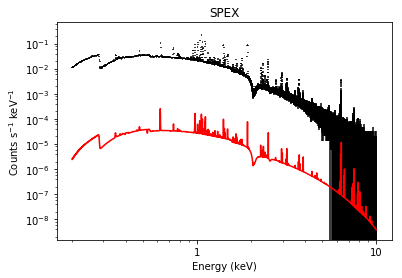

In [7]:
s.calc()
plt = s.plot_data(xlog=True, ylog=True, show=True)

Apparently, our guess for the normalisation was too low, but it looks like the model is close enough to the data to attempt a fit: 

In [8]:
s.fit()
print(s.fit_cstat())

(604679.5, 24497)


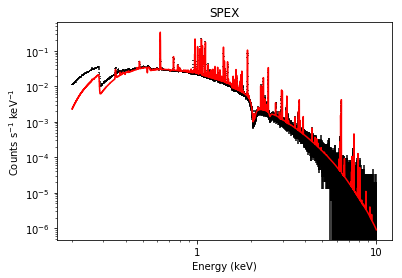

In [9]:
plt = s.plot_data(xlog=True, ylog=True, show=True)

In the fit, we apparently forgot to free the Galactic absorption, so we try again:

(209777.53125, 24496)


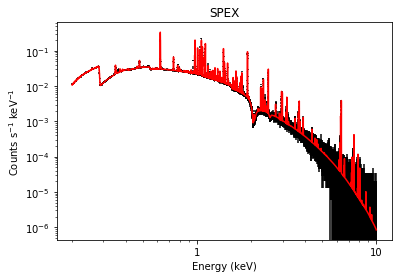

In [10]:
s.par_free(1, 2, 'nh')
s.fit()
print(s.fit_cstat())
plt = s.plot_data(xlog=True, ylog=True, show=True)

Unfortunately, the fit is still rather bad. In our model, we are actually using the SPEXACT 2 model, but with XIFU we have such a high spectral resolution that we need more up-to-date models. So, we set SPEX to use the SPEXACT version 3 models (the fit can take a while...). 

(24135.498046875, 24496)


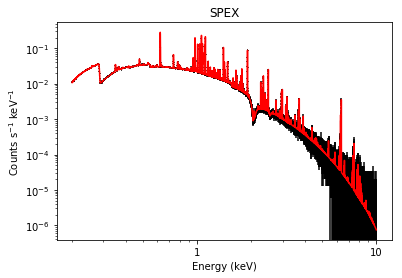

In [11]:
s.var_calc(True)
s.fit()
print(s.fit_cstat())
plt = s.plot_data(xlog=True, ylog=True, show=True)

Now the C-statistics values look a lot better. Is this a good fit? Check a copy of this notebook and see if you can improve it even more.